id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
mean=944.702 stdv=3118.312 max=86357
mean=834.707 stdv=653.218 max=9031
R-squared: 0.6078192360661809
MSE: 167164.95580791376


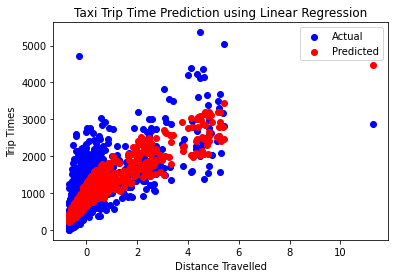

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import random
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import datetime
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

def getDistance(x1, y1, x2, y2):
    pickup = [float(x1), float(y1)]
    dropoff = [float(x2), float(y2)]
    pickupInRadians = [radians(_) for _ in pickup]
    dropOffInRadians = [radians(_) for _ in dropoff]
    result = haversine_distances([pickupInRadians, dropOffInRadians])
    return result[0][1] * 6371000/1000


def dateTimeToSingleValue(dateTime, valueType):
    date = datetime.datetime.strptime(dateTime, "%Y-%m-%d %H:%M:%S")
    if valueType == 0:
        return date.year
    elif valueType == 1:
        return date.month
    elif valueType == 2:
        return date.day
    elif valueType == 3:
        return date.hour
    elif valueType == 4:
        return date.minute
    else:
        return 'undefined'

def dateTimeToMillis(dateTime):
    return datetime.datetime.strptime(dateTime, "%Y-%m-%d %H:%M:%S").timestamp() * 1000

def timeToPeriod(inputTime):
    val = int(inputTime)
    if val >= 0 and val < 6:
        return 'overnight'
    elif val >= 6 and val < 12:
        return 'morning'
    elif val >= 12 and val < 18:
        return 'afternoon'
    elif val >= 18 and val <= 24:
        return 'evening'
    else:
        return 'undefined'

def weekdayOrWeekend(datetimeToCheck):
    dayNum = datetime.datetime.strptime(datetimeToCheck, "%Y-%m-%d %H:%M:%S").weekday()
    if dayNum < 5:
        return 'weekday'
    elif dayNum == 5 or dayNum == 6:
        return 'weekend'
    else:
        return 'undefined'

def monthToSeason(monthToCheck):
    val = int(monthToCheck)

    if val == 12 or val == 1 or val == 2:
        return 'winter'
    elif val > 2 and val <= 5:
        return 'spring'
    elif val > 5 and val <= 8:
        return 'summer'
    elif val > 8 and val <= 11:
        return 'fall'
    else:
        return 'undefined'

data_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/luke.couture@ucalgary.ca/train.csv").toPandas()
data = data_df.sample(10000, replace=False)

# data_test = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/luke.couture@ucalgary.ca/test.csv").toPandas()

# Check number of Nulls
print(data.isnull().sum(axis = 0))

data['distance_travelled'] = data.apply(lambda x: getDistance(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)
# data['timestamp_millis'] = data['pickup_datetime'].map(dateTimeToMillis)
data['pickup_year'] = data.apply(lambda x: dateTimeToSingleValue(x['pickup_datetime'], valueType=0), axis=1)
data['pickup_month'] = data.apply(lambda x: dateTimeToSingleValue(x['pickup_datetime'], valueType=1), axis=1)
data['pickup_day'] = data.apply(lambda x: dateTimeToSingleValue(x['pickup_datetime'], valueType=2), axis=1)
data['pickup_hour'] = data.apply(lambda x: dateTimeToSingleValue(x['pickup_datetime'], valueType=3), axis=1)
data['pickup_minute'] = data.apply(lambda x: dateTimeToSingleValue(x['pickup_datetime'], valueType=4), axis=1)
data['pickup_period'] = data['pickup_hour'].map(timeToPeriod)
data['pickup_day_type'] = data['pickup_datetime'].map(weekdayOrWeekend)
data['pickup_season'] = data['pickup_month'].map(monthToSeason)

# # Remove any Nulls
# data.dropna(subset=['MOST_SEVERE_INJURY'], inplace=True)

# Detect and remove outliers based on trip durations greater than: mean + (4 * sd)
print('mean=%.3f stdv=%.3f max=%d' % (np.mean(data['trip_duration'].astype(int)), np.std(data['trip_duration'].astype(int)), np.max(data['trip_duration'].astype(int))))
sd_y = np.std(data['trip_duration'].astype(int))
mean_y = np.mean(data['trip_duration'].astype(int))
outlier_value = mean_y + (4 * sd_y)
data.drop(data[(data.trip_duration.astype(int) > outlier_value) | (data.trip_duration.astype(int) < 0)].index, inplace=True)
print('mean=%.3f stdv=%.3f max=%d' % (np.mean(data['trip_duration'].astype(int)), np.std(data['trip_duration'].astype(int)), np.max(data['trip_duration'].astype(int))))

category_column_names = [
                'vendor_id',
                'pickup_year',
                'pickup_period',
                'pickup_day_type',
                'pickup_season'
                ]

number_column_names = [
                'pickup_minute',
                'passenger_count',
                'distance_travelled'
                ]

# copy category columns, create dummy vars, copy number columns, join both
df = data[category_column_names].copy()
category_columns_df = pd.get_dummies(df, columns=category_column_names, drop_first=True)
number_columns_df = data.loc[:,number_column_names].fillna(0)
joined_df = category_columns_df.join(number_columns_df)

# display(joined_df)

X = joined_df
y = data['trip_duration'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# NN regression
regr = MLPRegressor(max_iter=10000, hidden_layer_sizes=(32, 16), random_state=1)

# Train the model on the training data
regr.fit(X_train, y_train)
 
# Make predictions on the test data
y_pred = regr.predict(X_test)

# R Squared
print(f'R-squared: {r2_score(y_test, y_pred)}')

# MSE
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

# Visualize the test predictions for the distance_travlled
plt.scatter(X_test[:, -1], y_test, color='blue', label='Actual')
plt.scatter(X_test[:, -1], y_pred, color='red', label='Predicted')
plt.xlabel('Distance Travelled')
plt.ylabel('Trip Times')
plt.title('Taxi Trip Time Prediction using Linear Regression')
plt.legend()
plt.show()